In [45]:
import numpy as np
import netCDF4 as nc
import pylab as plt
import pandas as pd
import scipy.interpolate
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
from datetime import datetime, date

data_dir = '/projects/awaken/j3lee/arm-data/'
date = '20180610'
# date = '20170628'
output_dir = '/home/jlee/awaken/j3lee/sgp-obs-forcing/'+date+'/'
output_version = '3z'

# forward time adjustment from 0 UTC in hours
hour_adj = 3
# length of simulation in hours
sim_length = 3

# Adjust flux data filename if needed

In [46]:
# SURFACE FLUX DATA FILE
flx_file = 'sgpco2flx25mC1/sgpco2flx25mC1.b1.{}.001500.custom.nc'.format(date)
# flx_file = 'sgpco2flx25mC1/sgpco2flx25mC1.b1.{}.001500.nc'.format(date)
flx = nc.Dataset(data_dir+flx_file)

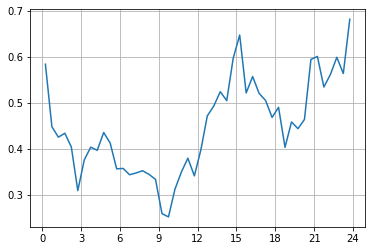

In [47]:
plt.plot(flx.variables['time'][:]/3600, flx.variables['friction_velocity'][:])
plt.xticks(np.arange(0, 27, 3))
plt.grid(True)

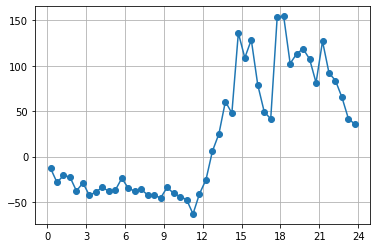

In [48]:
plt.plot(flx.variables['time'][:]/3600, flx.variables['sensible_heat_flux'][:], '-o')
plt.xticks(np.arange(0, 27, 3))
plt.grid(True)

# Adjust simulation start time if needed

In [49]:
# amr-wind starts at 0 second
# add 30 seconds offset for sgpinterpolatedsondeC1
flx_time_reset = flx.variables['time'][:] - hour_adj*3600 + 30
tflux = flx.variables['sensible_heat_flux'][:]\
        /flx.variables['air_density'][:]/flx.variables['air_heat_capacity'][:]

# Adjust interpsonde filename if needed

In [50]:
def load_interpsonde_as_df_profile(filepath):
    
    ds = xr.open_dataset(filepath)
    
    df = ds.to_dataframe()
    df.reset_index(level=[1], drop=False, inplace=True)
    df.set_index(['time_offset'], drop=True, inplace=True, append=True)
#     df2 = df.reorder_levels([1,0])

    return df

In [51]:
fp = data_dir\
     +'sgpinterpolatedsondeC1/sgpinterpolatedsondeC1.c1.{}.000030.custom.nc'.format(date)
# fp = data_dir\
#      +'sgpinterpolatedsondeC1/sgpinterpolatedsondeC1.c1.{}.000030.nc'.format(date)

interpsonde_df = load_interpsonde_as_df_profile(fp)

# Adjust time window if needed

In [52]:
# IMPORTANT--THIS GIVES THE TIME SLICE OF PROFILE DATA

ymd = date[:4]+'-'+date[4:6]+'-'+date[6:]
# start = '2018-06-10 03:00:30'

def convert_hr_to_string(t):
    if t <= 10: 
        out = '0'+str(t)
    else: 
        out = str(t)
    return out
    
start_t = ymd+' '+convert_hr_to_string(hour_adj)+':00:30'

end_t = ymd+' '+convert_hr_to_string(hour_adj+sim_length)+':00:30'

df2 = interpsonde_df.reorder_levels([1, 0]).unstack()
dfp_ = df2.loc[start_t:end_t, :].stack()
# 20180611

# Adjust domain height and vertical resolution if needed

In [53]:
dom_height = 3200
dz = 20
amr_height = np.arange(dz*0.5, dom_height,dz)

In [54]:
obs_height = np.array(interpsonde_df.xs(start_t, level=1).index) * 1000
obs_height = obs_height - obs_height[0]

In [55]:
def interp_heights(data_heights, data_variable, forcing_heights):
    
    nt=np.shape(data_variable)[0]
    nh = np.shape(forcing_heights)[0]
    forcing_variable=np.zeros((nt, nh))
    
    for i in range(nt):
        
        h1= data_heights[:]
        v1 = data_variable[i, :]
        xp = h1[h1>=0]
        yp = v1[h1>=0]
        y = np.interp(forcing_heights, xp, yp)

        forcing_variable[i, :] = y[:]
        
    return forcing_variable

def get_amr_var(df, key, obs_height, amr_height):
    nvals = len(df[key].values)
    nh = len(obs_height)
    var_amr = interp_heights(obs_height, 
                             df[key].values.reshape(int(nvals/nh), nh), amr_height)
    return var_amr

def get_exner(p):
    return (p/1.0e5)**(287.1/1004.0)

In [56]:
u_amr = get_amr_var(dfp_, 'u_wind', obs_height,amr_height)
v_amr = get_amr_var(dfp_, 'v_wind', obs_height,amr_height)

Text(0.5, 1.0, 'Data interpolated in height')

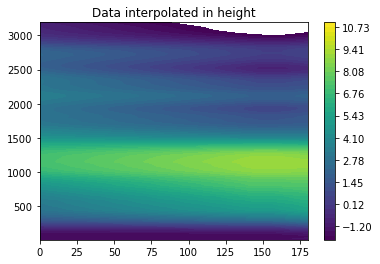

In [57]:
plt.contourf(np.arange((sim_length*60)+1), amr_height, u_amr.T, levels = np.linspace(-2, 11))
plt.colorbar()
plt.title('Data interpolated in height')

In [58]:
# plt.contourf(np.arange(360), obs_height,dfp_['u_wind'].values.reshape(int(nvals/nh),nh).T,levels = np.linspace(-2,11))
# plt.ylim(0,3000)
# plt.colorbar()
# plt.title('Original Data')

In [59]:
p_amr = get_amr_var(dfp_, 'bar_pres', obs_height, amr_height)* 1000

T_amr = get_amr_var(dfp_, 'temp', obs_height, amr_height) + 273.15

dims = np.shape(T_amr)
for i in np.arange(dims[0]):
    for j in np.arange(dims[1]):
        T_amr[i, j] = T_amr[i, j]/get_exner(p_amr[i, j])

Text(0.5, 1.0, 'Data interpolated in height')

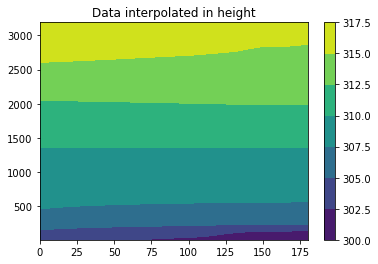

In [60]:
plt.contourf(np.arange((sim_length*60)+1), amr_height, T_amr.T)
plt.colorbar()
plt.title('Data interpolated in height')

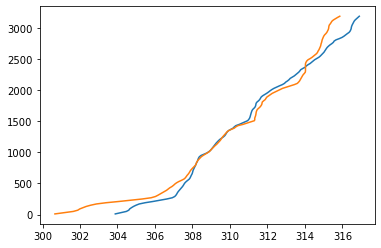

In [61]:
plt.plot(T_amr[0, :], amr_height)
plt.plot(T_amr[-1, :], amr_height)

# Create the forcing file

# Adjust filenames if needed 

In [62]:
forcing_file_name = output_dir+'forcing_{}_v{}.nc'.format(date, output_version)
ncfile = nc.Dataset(forcing_file_name, mode='w', format='NETCDF4_CLASSIC')
# DIMENSIONS
amr_time = np.arange(T_amr.shape[0]) * 60.0
nheight = ncfile.createDimension('nheight', len(amr_height))
ntime = ncfile.createDimension('ntime', len(amr_time))
arraySize = ncfile.createDimension('arraySize', len(amr_time)*len(amr_height))

# VARIABLES

heights = ncfile.createVariable('heights', 'f8', ('nheight',))
heights[:] = amr_height[:]

times  = ncfile.createVariable('times', 'f8', ('ntime',))
times[:] = amr_time[:]

wrf_momentum_u = ncfile.createVariable('wrf_momentum_u', 'f8', ('arraySize', ))

wrf_momentum_u[:] = u_amr.ravel(order='C')

wrf_momentum_v = ncfile.createVariable('wrf_momentum_v', 'f8', ('arraySize', ))

wrf_momentum_v[:] = v_amr.ravel(order='C')

wrf_temperature = ncfile.createVariable('wrf_temperature', 'f8', ('arraySize', ))
wrf_temperature[:] = T_amr.ravel(order='C')

f = scipy.interpolate.interp1d(flx_time_reset, tflux, fill_value='extrapolate')
tflux_interp = f(amr_time)

wrf_tflux = ncfile.createVariable('wrf_tflux', 'f8', ('ntime', ))
wrf_tflux[:] = tflux_interp

ncfile.close()

# Initial Data file

In [63]:
initial_file_name = output_dir+'initial_{}_v{}.nc'.format(date, output_version)
ncfile = nc.Dataset(initial_file_name, mode='w', format='NETCDF4_CLASSIC')
nheight = ncfile.createDimension('nheight', len(amr_height))
heights = ncfile.createVariable('heights', 'f8', ('nheight',))
heights[:] = amr_height[:]

u = ncfile.createVariable('u', 'f8', ('nheight'))

u[:] = u_amr[0, :]

v = ncfile.createVariable('v', 'f8', ('nheight'))
v[:] = v_amr[0, :]

theta = ncfile.createVariable('theta', 'f8', ('nheight'))
theta[:] = T_amr[0, :]

ncfile.close()

In [133]:
# Get w'T'

In [134]:
print(tflux_interp[0])

0.2835101882616679


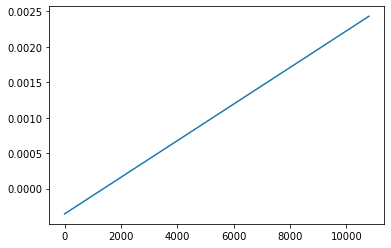

In [136]:
tgrad = np.zeros(len(amr_time))
tgrad2 = np.zeros(len(amr_time))
for i, time in enumerate(amr_time):
    tgrad[i] = (T_amr[i, -1]-T_amr[i, -2])/dz
#     tgrad2[i] = (T_amr[i,150]-T_amr[i,149])/dz
    
plt.plot(amr_time, tgrad)
# plt.plot(amr_time,tgrad2)

In [27]:
print(amr_time)

[    0.    60.   120.   180.   240.   300.   360.   420.   480.   540.
   600.   660.   720.   780.   840.   900.   960.  1020.  1080.  1140.
  1200.  1260.  1320.  1380.  1440.  1500.  1560.  1620.  1680.  1740.
  1800.  1860.  1920.  1980.  2040.  2100.  2160.  2220.  2280.  2340.
  2400.  2460.  2520.  2580.  2640.  2700.  2760.  2820.  2880.  2940.
  3000.  3060.  3120.  3180.  3240.  3300.  3360.  3420.  3480.  3540.
  3600.  3660.  3720.  3780.  3840.  3900.  3960.  4020.  4080.  4140.
  4200.  4260.  4320.  4380.  4440.  4500.  4560.  4620.  4680.  4740.
  4800.  4860.  4920.  4980.  5040.  5100.  5160.  5220.  5280.  5340.
  5400.  5460.  5520.  5580.  5640.  5700.  5760.  5820.  5880.  5940.
  6000.  6060.  6120.  6180.  6240.  6300.  6360.  6420.  6480.  6540.
  6600.  6660.  6720.  6780.  6840.  6900.  6960.  7020.  7080.  7140.
  7200.  7260.  7320.  7380.  7440.  7500.  7560.  7620.  7680.  7740.
  7800.  7860.  7920.  7980.  8040.  8100.  8160.  8220.  8280.  8340.
  8400

In [28]:
print(amr_height)

[  10.   30.   50.   70.   90.  110.  130.  150.  170.  190.  210.  230.
  250.  270.  290.  310.  330.  350.  370.  390.  410.  430.  450.  470.
  490.  510.  530.  550.  570.  590.  610.  630.  650.  670.  690.  710.
  730.  750.  770.  790.  810.  830.  850.  870.  890.  910.  930.  950.
  970.  990. 1010. 1030. 1050. 1070. 1090. 1110. 1130. 1150. 1170. 1190.
 1210. 1230. 1250. 1270. 1290. 1310. 1330. 1350. 1370. 1390. 1410. 1430.
 1450. 1470. 1490. 1510. 1530. 1550. 1570. 1590. 1610. 1630. 1650. 1670.
 1690. 1710. 1730. 1750. 1770. 1790. 1810. 1830. 1850. 1870. 1890. 1910.
 1930. 1950. 1970. 1990. 2010. 2030. 2050. 2070. 2090. 2110. 2130. 2150.
 2170. 2190. 2210. 2230. 2250. 2270. 2290. 2310. 2330. 2350. 2370. 2390.
 2410. 2430. 2450. 2470. 2490. 2510. 2530. 2550. 2570. 2590. 2610. 2630.
 2650. 2670. 2690. 2710. 2730. 2750. 2770. 2790. 2810. 2830. 2850. 2870.
 2890. 2910. 2930. 2950. 2970. 2990. 3010. 3030. 3050. 3070. 3090. 3110.
 3130. 3150. 3170. 3190.]
